<a href="https://colab.research.google.com/github/CheshireCat12/Deep_learning_challenges/blob/master/AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.autograd import Variable
from torch.utils.data import DataLoader

In [0]:
DOWNLOAD_DATASET = True
BATCH_SIZE = 128
NB_TEST_IMG = 5
NB_EPOCHS = 100
DEVICE= torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
norm_mean = [0.1307]
norm_std = [0.3081]

pre_process = transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize(
                                    mean=norm_mean,
                                    std=norm_std)])

train_data = datasets.MNIST(root='./data',
                            train=True,
                            transform=pre_process,
                            download=True)
 
train_loader = DataLoader(train_data,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

In [0]:
class AutoEncoder(nn.Module):
    
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        return encoded, decoded

In [0]:
autoencoder = AutoEncoder()
autoencoder.to(DEVICE)
print(autoencoder)

optimizer = torch.optim.Adam(autoencoder.parameters())
loss_func = nn.MSELoss()

view_data = Variable(train_data.data[:NB_TEST_IMG].view(-1, 28*28).type(torch.cuda.FloatTensor))

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): ReLU()
    (6): Linear(in_features=12, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=True)
    (1): ReLU()
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Sigmoid()
  )
)


In [0]:
def train(model, data_loader, view_data, loss_func):
    for epoch in range(NB_EPOCHS):
        for step, (x, _) in enumerate(data_loader):
            x = Variable(x.view(-1, 28*28)).to(DEVICE)
            y = Variable(x.view(-1, 28*28)).to(DEVICE)
            
            # ===================forward=====================
            encoded, decoded = model(x)
            loss = loss_func(decoded, y)
            
            # ===================backward=====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if not step % 500 and epoch in [i for i in range(0, NB_EPOCHS, 4)]:
                print(f'Epoch: {epoch} | Loss: {loss.item():.4f}')
                
                _, decoded_data = model(view_data)
                
                f, a = plt.subplots(2, NB_TEST_IMG, figsize=(10, 4))
                
                for i in range(NB_TEST_IMG):
                    a[0][i].imshow(np.reshape(view_data.cpu().data.numpy()[i],
                                               (28, 28)),
                                               cmap='gray')
                    a[0][i].set_xticks(())
                    a[0][i].set_yticks(())
                
                    
                for i in range(NB_TEST_IMG):
                    a[1][i].imshow(np.reshape(decoded_data.cpu().data.numpy()[i],
                                               (28, 28)),
                                               cmap='gray')
                    a[1][i].set_xticks(())
                    a[1][i].set_yticks(())
                plt.show()
            

Epoch: 0 | Loss: 0.2320


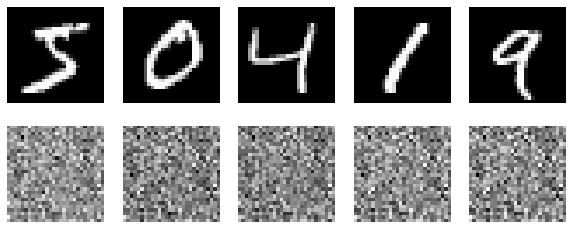

Epoch: 0 | Loss: 0.0528


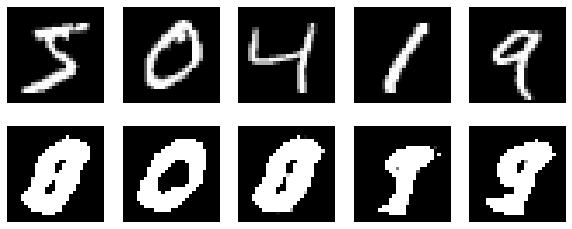

Epoch: 4 | Loss: 0.0337


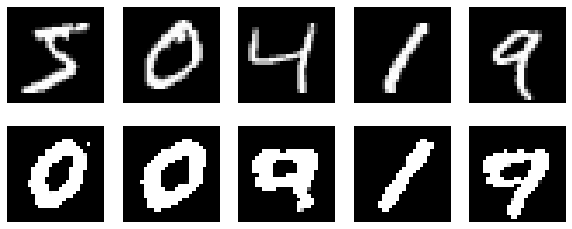

Epoch: 4 | Loss: 0.0377


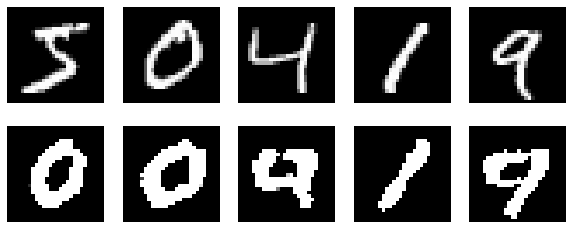

Epoch: 8 | Loss: 0.0371


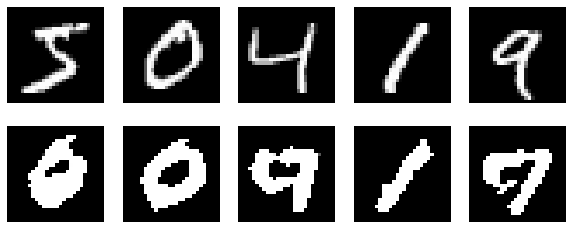

Epoch: 8 | Loss: 0.0334


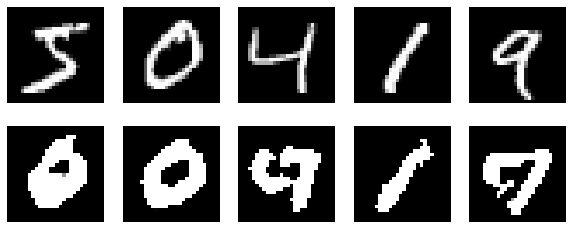

In [0]:
train(autoencoder, train_loader, view_data, loss_func)